# Imports

In [15]:
# Imports
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Load
This is where the prepared data is loaded in for use in training and testing of the model

In [16]:
# Load cleaned and preprocessed data
X_train = pd.read_csv("data/X_train.csv", index_col=0).astype(float)
y_train = pd.read_csv("data/y_train.csv", index_col=0).astype(int)
y_train = pd.Series(y_train.values.ravel())
y_train.index = X_train.index
y_train_binary = pd.read_csv("data/y_train_binary.csv", index_col=0).astype(int)
y_train_binary = pd.Series(y_train_binary.values.ravel())
y_train_binary.index = X_train.index
X_test = pd.read_csv("data/X_test.csv", index_col=0).astype(float)
y_test = pd.read_csv("data/y_test.csv", index_col=0).astype(int)
y_test = pd.Series(y_test.values.ravel())
y_test.index = X_test.index
y_test_binary = pd.read_csv("data/y_test_binary.csv", index_col=0).astype(int)
y_test_binary = pd.Series(y_test_binary.values.ravel())
y_test_binary.index = X_test.index

# Two Stage Logistic Regression with Cross Validation Model
This section is where the two stage logistic regression cv model is trained and tested. First class 1 and class 2 are merged into a single class and a logistic regression cv model is trained to predict class 0 against the combined class 1 and 2. A second model is then trained to predict class 1 against class 2. The output of these two models is then combined to create a prediction of all classes

In [17]:
#Model parameters
desired_cs = np.logspace(-3, 2, 30)
desired_cv = 10

# Train first Model: 0 vs (1+2)
first_model = LogisticRegressionCV(
    Cs=desired_cs,
    cv=desired_cv,
    solver='lbfgs',
    max_iter=1000,
    class_weight='balanced'
)
first_model.fit(X_train, y_train_binary)


# Predict first stage
y_pred_binary = first_model.predict(X_test)

print("\nFirst Stage Classification Report (class 0 vs class 1+2):")
print(classification_report(y_test_binary, y_pred_binary))

# Stage 2: 1 vs 2
# Get original test labels with 0/1/2
y_test_full = y_test.loc[y_test_binary.index]

# Find samples predicted as diabetic
indices_pred_diabetes = np.where(y_pred_binary == 1)[0]
X_test_diabetes = X_test.iloc[indices_pred_diabetes]
y_test_diabetes = y_test_full.iloc[indices_pred_diabetes]

# Keep only class 1 and 2
# Pull records where y_test_diabetes is class 1 or class 2, along with their indexes
test_diabetes = y_test_diabetes.loc[(y_test_diabetes == 1) | (y_test_diabetes == 2)].index
X_test_diabetes = X_test_diabetes.loc[test_diabetes]
y_test_diabetes = y_test_diabetes.loc[test_diabetes]

# Prepare second-stage training data
# Get the indexes where y_train_binary == 1
diabetes_indexes = y_train_binary.loc[y_train_binary == 1].index

# Use these indexes to select records from X_train_diabetes and y_train_diabetes
X_train_diabetes = X_train.loc[diabetes_indexes]
y_train_diabetes = y_train.loc[diabetes_indexes]

second_model = LogisticRegressionCV(
    Cs=desired_cs,
    cv=desired_cv,
    solver='lbfgs',
    max_iter=1000,
    class_weight='balanced'
)
second_model.fit(X_train_diabetes, y_train_diabetes)

# Predict on the subset
y_pred_second_stage = second_model.predict(X_test_diabetes)

print("\nSecond Stage Classification Report (class 1 vs class 2):")
print(classification_report(y_test_diabetes, y_pred_second_stage))

# Reconstruct final prediction array
y_pred_final = y_pred_binary.copy()
pred_diabetes_indices = np.where(y_pred_binary == 1)[0]

# Reindex and assign
y_test_full_diabetes = y_test_full.iloc[pred_diabetes_indices]
valid_indices = pred_diabetes_indices[(y_test_full_diabetes == 1) | (y_test_full_diabetes == 2)]

for i, idx in enumerate(valid_indices):
    y_pred_final[idx] = y_pred_second_stage[i]

print("\nFinal SVM Classification Report:")
print(classification_report(y_test_full, y_pred_final))


First Stage Classification Report (class 0 vs class 1+2):
              precision    recall  f1-score   support

           0       0.94      0.67      0.79     38012
           1       0.34      0.79      0.47      7945

    accuracy                           0.69     45957
   macro avg       0.64      0.73      0.63     45957
weighted avg       0.83      0.69      0.73     45957


Second Stage Classification Report (class 1 vs class 2):
              precision    recall  f1-score   support

           1       0.15      0.40      0.21       634
           2       0.92      0.73      0.82      5635

    accuracy                           0.70      6269
   macro avg       0.53      0.57      0.52      6269
weighted avg       0.84      0.70      0.75      6269


Final SVM Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.67      0.79     38012
           1       0.02      0.28      0.03       926
           2       0.92      0.5

# Export
This section is where the final predictions of the two stage logistic regression cv model are exported for use by the ensemble

In [18]:
# Save test data to be later used in the ensemble voting
os.makedirs("results", exist_ok=True)
np.save("results/y_pred_lr.npy", y_pred_final)

# Plot ROC/AUC curves for 2-Stage Logistic Regression Model with Undersampling

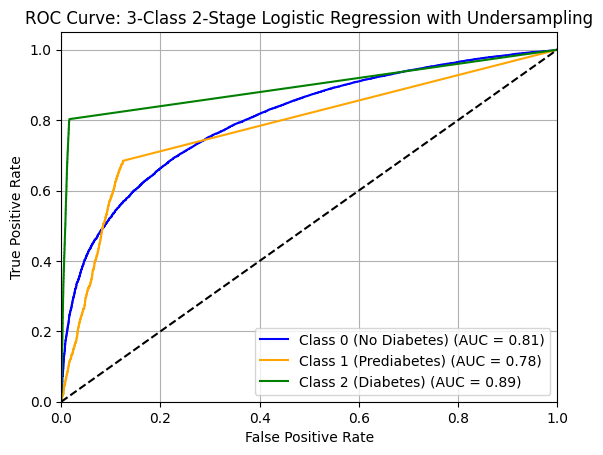

In [19]:
# Step 1: Get predicted probabilities from first stage (binary)
prob_first_stage = first_model.predict_proba(X_test)[:, 1]  # Probability of class 1 (diabetic)

# Step 2: Get predicted probabilities from second stage (1 vs 2)
# Only for samples predicted as diabetic
prob_second_stage = second_model.predict_proba(X_test_diabetes)

# Initialize full probability matrix for classes 0, 1, 2
# Shape: (n_samples, 3)
y_score = np.zeros((len(X_test), 3))

# Class 0 probability = 1 - prob_first_stage
y_score[:, 0] = 1 - prob_first_stage

# For predicted diabetic samples (class 1 or 2)
# Map them back to full test set
for i, global_idx in enumerate(test_diabetes):
    prob_1 = prob_second_stage[i, 0]  # Class 1
    prob_2 = prob_second_stage[i, 1]  # Class 2
    diabetes_prob = prob_first_stage[X_test.index.get_loc(global_idx)]
    
    y_score[X_test.index.get_loc(global_idx), 1] = diabetes_prob * prob_1
    y_score[X_test.index.get_loc(global_idx), 2] = diabetes_prob * prob_2

# Binarize y_test for ROC curve
y_test_bin = label_binarize(y_test_full, classes=[0, 1, 2])

# Step 4: Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = ['blue', 'orange', 'green']
labels = ['Class 0 (No Diabetes)', 'Class 1 (Prediabetes)', 'Class 2 (Diabetes)']

for i in range(3):
    plt.plot(fpr[i], tpr[i], color=colors[i],
             label=f'{labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: 3-Class 2-Stage Logistic Regression with Undersampling')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()